In [1]:
import os, glob, ast, pandas as pd
import torch
def load_early_stop_csvs(csv_dir: str, split: str):
    """
    Load and concatenate all GSM8K early-stop CSVs for a given split.
    Expects files named like gsm8k_Y_train_0.csv, gsm8k_Y_train_1.csv, ...
    Returns a DataFrame with columns ['question_text', 'labels'].
    """
    pattern = os.path.join(csv_dir, f"gsm8k_Y_{split}_*.csv")
    paths = sorted(glob.glob(pattern))
    if not paths:
        raise FileNotFoundError(f"No files matched {pattern}")
    dfs = []
    for p in paths:
        df = pd.read_csv(p, usecols=["question_text", "early_stop_correct_proportions"])
        # parse the string "[0.12, 0.34, …]" into a Python list of floats
        df["labels"] = df["early_stop_correct_proportions"].apply(ast.literal_eval)
        dfs.append(df[["question_text", "labels"]])
    full_df = pd.concat(dfs, ignore_index=True)
    return full_df

# Example usage:
train_df = load_early_stop_csvs("/n/home04/amuppidi/reasoning-scheduling/data/gsm8k_results", "train")
test_df  = load_early_stop_csvs("/n/home04/amuppidi/reasoning-scheduling/data/gsm8k_results", "test")

# Then wrap them into EarlyStopDataset:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B", use_fast=True)

class EarlyStopDataset(torch.utils.data.Dataset):
    def __init__(self, df: pd.DataFrame, tokenizer, max_length=512):
        self.prompts = df["question_text"].tolist()
        self.labels  = df["labels"].tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.prompts)

    def __getitem__(self, idx):
        enc = self.tokenizer(
            self.prompts[idx],
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt",
        )
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.float)
        return item

train_dataset = EarlyStopDataset(train_df, tokenizer)
eval_dataset  = EarlyStopDataset(test_df, tokenizer)



===== Train Set =====
Total examples: 7450
Label‐length counts: {16: 7450}


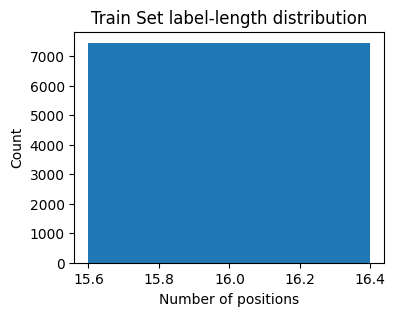

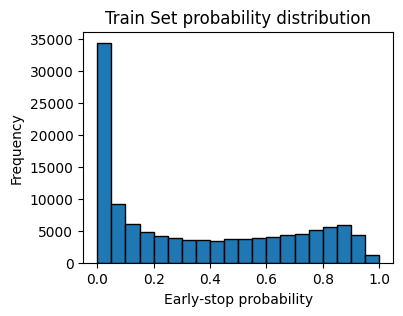

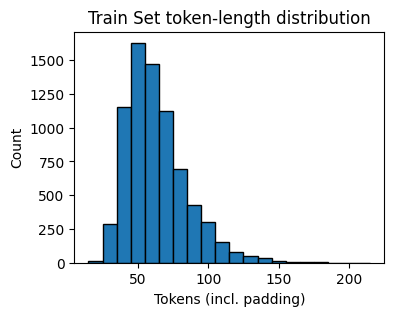


-- Train Set random samples (5) --
[6404] prompt excerpt: <｜User｜>Martha's cat catches 3 rats and 7 birds. Cara's cat catches 3 less than five times as many animals as Martha's cat. How many animals does Cara's cat catch?<｜Assistant｜>
     labels: [0.   0.   0.   0.01 0.06 0.12 0.13 0.34 0.48 0.53 0.51 0.54 0.49 0.57
 0.55 0.57]

[5651] prompt excerpt: <｜User｜>A parking garage near Nora's house is 4 stories tall. There are 100 spots per level. There are 58 open parking spots on the first level. There are 2 more open parking spots on the second level…
     labels: [0.   0.01 0.01 0.   0.01 0.   0.   0.   0.   0.02 0.05 0.36 0.59 0.58
 0.76 0.81]

[1514] prompt excerpt: <｜User｜>Matt did his homework for 150 minutes. He spent 30% of that time on math and 40% on science. He spent the remaining time on other subjects. How much time did Matt spend on homework in other su…
     labels: [0.45 0.5  0.29 0.19 0.28 0.35 0.49 0.56 0.57 0.64 0.62 0.69 0.69 0.66
 0.67 0.66]

[6347] prompt excerpt: 

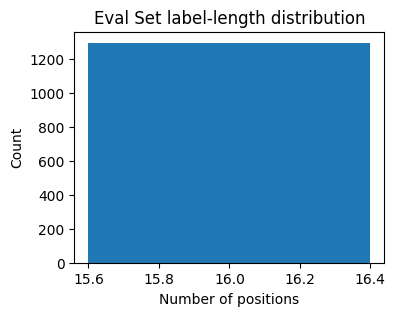

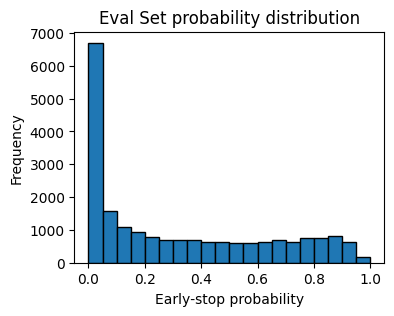

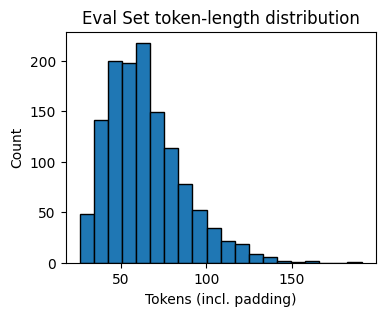


-- Eval Set random samples (5) --
[521] prompt excerpt: <｜User｜>Josie grows grapes on her 10-acre farm.  Each acre produces 5 tons of grapes per year, and each ton of grapes makes 2 barrels of wine.  How many barrels of wine does her farm produce per year?…
     labels: [0.2  0.09 0.04 0.02 0.49 0.79 0.79 0.86 0.79 0.72 0.79 0.77 0.72 0.72
 0.81 0.82]

[91] prompt excerpt: <｜User｜>Jan has three times the number of pets as Marcia. Marcia has two more pets than Cindy. If Cindy has four pets, how many total pets do the three have?<｜Assistant｜>
     labels: [0.05 0.   0.01 0.05 0.49 0.36 0.45 0.65 0.59 0.66 0.69 0.66 0.65 0.71
 0.67 0.65]

[337] prompt excerpt: <｜User｜>Donny can only drink water if it's at least 40 degrees. He has two mugs of water. One mug is 33 degrees. The other is an unknown temperature. If he pours 4 ounces of water from the 33-degree m…
     labels: [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.01 0.
 0.   0.01]

[1092] prompt excerpt: <｜User｜>When 

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt

def summarize_dataset(dataset, name, tokenizer=None, num_samples=5):
    print(f"\n===== {name} =====")
    # 1) Basic counts
    N = len(dataset)
    print(f"Total examples: {N}")

    # 2) Check label lengths (should all be equal to num_positions)
    label_lengths = [item["labels"].shape[0] for item in dataset]
    lengths_counter = {l: label_lengths.count(l) for l in sorted(set(label_lengths))}
    print("Label‐length counts:", lengths_counter)

    # 3) Histogram of label lengths
    plt.figure(figsize=(4,3))
    plt.bar(lengths_counter.keys(), lengths_counter.values(), width=0.8)
    plt.title(f"{name} label‐length distribution")
    plt.xlabel("Number of positions")
    plt.ylabel("Count")
    plt.show()

    # 4) Flatten all label values and plot distribution
    all_labels = np.concatenate([item["labels"].cpu().numpy() for item in dataset])
    plt.figure(figsize=(4,3))
    plt.hist(all_labels, bins=20, edgecolor="k")
    plt.title(f"{name} probability distribution")
    plt.xlabel("Early‐stop probability")
    plt.ylabel("Frequency")
    plt.show()

    # 5) Token‐length distribution (optional)
    try:
        token_lengths = [item["attention_mask"].sum().item() for item in dataset]
        plt.figure(figsize=(4,3))
        plt.hist(token_lengths, bins=20, edgecolor="k")
        plt.title(f"{name} token‐length distribution")
        plt.xlabel("Tokens (incl. padding)")
        plt.ylabel("Count")
        plt.show()
    except KeyError:
        pass  # if you didn’t store masks

    # 6) Print a few random samples
    print(f"\n-- {name} random samples ({num_samples}) --")
    for idx in random.sample(range(N), num_samples):
        item = dataset[idx]
        text = tokenizer.decode(item["input_ids"], skip_special_tokens=True) if tokenizer else "<no tokenizer>"
        labels = item["labels"].cpu().numpy()
        print(f"[{idx}] prompt excerpt:", text[:200].replace("\n"," ") + ("…" if len(text)>200 else ""))
        print("     labels:", np.round(labels,2))
        print()

# Usage (after you’ve defined train_dataset, eval_dataset, tokenizer):
summarize_dataset(train_dataset, "Train Set", tokenizer)
summarize_dataset(eval_dataset,  "Eval Set",  tokenizer)


In [3]:
def collate_fn(batch):
    # pad everything to the max in this batch
    input_ids = torch.stack([b["input_ids"] for b in batch])
    attention_mask = torch.stack([b["attention_mask"] for b in batch])
    labels = torch.stack([b["labels"] for b in batch])
    return {"input_ids": input_ids, "attention_mask": attention_mask, "labels": labels}

In [4]:
import torch.nn as nn
from transformers import AutoModelForCausalLM
from peft import LoraConfig, get_peft_model, TaskType
from transformers.modeling_outputs import SequenceClassifierOutput
import torch.nn.functional as F

class EarlyStopFinetuner(nn.Module):
    def __init__(
        self,
        base_model_name: str,
        num_positions: int,
        use_lora: bool = False,
        lora_r: int = 16,
        lora_alpha: int = 32,
    ):
        super().__init__()
        # load base LM
        self.lm = AutoModelForCausalLM.from_pretrained(
            base_model_name,
            output_hidden_states=True,  # we only need last hidden state
            attn_implementation="flash_attention_2",
            device_map="cuda",  # automatically use available GPUs
            cache_dir="/n/holylabs/LABS/dwork_lab/Everyone/cache/transformers",  # uncomment if you want to use a specific cache dir
            # if you want fp16
        )
        
        #        tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True, cache_dir="/n/holylabs/LABS/dwork_lab/Everyone/cache/transformers")
        # model = AutoModelForCausalLM.from_pretrained(model_name, output_hidden_states=True, cache_dir="/n/holylabs/LABS/dwork_lab/Everyone/cache/transformers", device_map="cuda")
        #
        #
        
        hidden_size = self.lm.config.hidden_size

        # attach LoRA if requested
        if use_lora:
            peft_config = LoraConfig(
                task_type=TaskType.CAUSAL_LM,
                inference_mode=False,
                r=lora_r,
                lora_alpha=lora_alpha,
                lora_dropout=0.05,
                target_modules=["q_proj", "k_proj", "v_proj", "o_proj"]
            )
            self.lm = get_peft_model(self.lm, peft_config)

        # regression head: last hidden token → vector of length num_positions
        self.regressor = nn.Sequential(
            nn.LayerNorm(hidden_size),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, num_positions),
            nn.Sigmoid(),  # ensure outputs ∈ [0,1]
        )

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.lm(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_hidden_states=True,    # make sure we get .hidden_states
            return_dict=True,
        )
        # hidden_states is a tuple (embeddings, layer1, …, layerN)
        last_hidden = outputs.hidden_states[-1]           # shape (B, T, H)

        # pick off the last real token per sequence
        seq_lens = attention_mask.sum(dim=1) - 1
        last_h   = last_hidden[torch.arange(len(seq_lens)), seq_lens]

        # regression head
        logits = self.regressor(last_h)                   # (B, num_positions)

        loss = None
        if labels is not None:
            loss = F.mse_loss(logits, labels)

        return SequenceClassifierOutput(loss=loss, logits=logits)



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [5]:
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import numpy as np
from transformers import EvalPrediction

def compute_metrics(eval_pred):
    """
    eval_pred can be either:
      - an EvalPrediction with .predictions and .label_ids 
      - a tuple (preds, labels)
    preds and labels should be arrays of shape (batch_size, num_positions).
    We flatten them to compute global MSE and Pearson correlation.
    """
    # Unpack
    if isinstance(eval_pred, EvalPrediction):
        preds = eval_pred.predictions
        labels = eval_pred.label_ids
    else:
        preds, labels = eval_pred

    # Some models return a tuple (e.g. when returning logits+something), so grab the first element
    if isinstance(preds, tuple):
        preds = preds[0]

    # Convert to flat 1D arrays
    flat_preds  = preds.reshape(-1)
    flat_labels = labels.reshape(-1)

    # Compute metrics
    mse = mean_squared_error(flat_labels, flat_preds)
    pearson_r, _ = pearsonr(flat_labels, flat_preds)

    return {"mse": mse, "pearsonr": pearson_r}


In [ ]:
model_name    = "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B"
output_dir    = "/n/netscratch/gershman_lab/Lab/amuppidi/reasoning/early_stop_finetuned"
num_positions = 16
use_lora      = True

per_device_train_batch_size = 4
per_device_eval_batch_size  = 8
learning_rate              = 1e-4
num_train_epochs           = 3

# 2) -- IMPORTS --
from transformers import AutoTokenizer, Trainer, TrainingArguments
import accelerate
# 3) -- TOKENIZER & DATASETS --
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True, cache_dir="/n/netscratch/gershman_lab/Lab/amuppidi/reasoning/cache/transformers")

# Point at the folder where all the files live
csv_dir = "data/gsm8k_results"

# Load every shard for train & test
train_df = load_early_stop_csvs(csv_dir, "train")
valid_df = load_early_stop_csvs(csv_dir, "test")

# Wrap into your Dataset
train_ds = EarlyStopDataset(train_df, tokenizer)
eval_ds  = EarlyStopDataset(valid_df, tokenizer)

model = EarlyStopFinetuner(
    base_model_name=model_name,
    num_positions=num_positions,
    use_lora=use_lora,
)


You are attempting to use Flash Attention 2.0 without specifying a torch dtype. This might lead to unexpected behaviour
/n/home04/amuppidi/.conda/envs/torch/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:820: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(


In [7]:
for name, module in model.named_modules():
    if isinstance(module, torch.nn.Linear):
        print(name)


lm.base_model.model.model.layers.0.self_attn.q_proj.base_layer
lm.base_model.model.model.layers.0.self_attn.q_proj.lora_A.default
lm.base_model.model.model.layers.0.self_attn.q_proj.lora_B.default
lm.base_model.model.model.layers.0.self_attn.k_proj.base_layer
lm.base_model.model.model.layers.0.self_attn.k_proj.lora_A.default
lm.base_model.model.model.layers.0.self_attn.k_proj.lora_B.default
lm.base_model.model.model.layers.0.self_attn.v_proj.base_layer
lm.base_model.model.model.layers.0.self_attn.v_proj.lora_A.default
lm.base_model.model.model.layers.0.self_attn.v_proj.lora_B.default
lm.base_model.model.model.layers.0.self_attn.o_proj.base_layer
lm.base_model.model.model.layers.0.self_attn.o_proj.lora_A.default
lm.base_model.model.model.layers.0.self_attn.o_proj.lora_B.default
lm.base_model.model.model.layers.0.mlp.gate_proj
lm.base_model.model.model.layers.0.mlp.up_proj
lm.base_model.model.model.layers.0.mlp.down_proj
lm.base_model.model.model.layers.1.self_attn.q_proj.base_layer
lm.b

In [ ]:

# 4) -- MODEL --


# 5) -- TRAINING ARGS --
training_args = TrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=per_device_train_batch_size,
    per_device_eval_batch_size=per_device_eval_batch_size,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=learning_rate,
    num_train_epochs=num_train_epochs,
    fp16=False,
    bf16=True,  # set to True if you want to use bfloat16
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="mse",
    remove_unused_columns=True,
    report_to=None,  # or "tensorboard" if you prefer
)

# 6) -- TRAINER SETUP --
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=eval_ds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
)
import wandb
#wandb.init(mode='disabled')
# 7) -- RUN TRAINING --
trainer.train()

# 8) -- SAVE FINAL MODEL --
trainer.save_model(output_dir)


Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
The input hidden states seems to be silently casted in float32, this might be related to the fact you have upcasted embedding or layer norm layers in float32. We will cast back the input in torch.bfloat16.


Epoch,Training Loss,Validation Loss


In [16]:
import wandb
wandb.finish()